In [15]:
# Solving libraries
import numpy as np

# Plotting libraries
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Datasets
from sklearn.datasets import make_circles

In [16]:
class NeuralLayer():
    
    def __init__(self, pos, prev_neurons, n_neurons, activation):
        
        self.pos = pos
        self.neurons = n_neurons

        if prev_neurons != None:
            self.act_f = activation
            self.b = np.random.rand(1,n_neurons) * 2 - 1 # Columns: 1 // Rows: n_neurons
            self.W = np.random.rand(prev_neurons,n_neurons) * 2 - 1 # Columns:2 prev_neurons // Rows: n_neurons
            self.type = 'hidden'

        else:
            self.act_f = None
            self.type = 'input'

    def __len__(self):
        return self.neurons

    def __str__(self, neurons_spacing = 4, width = 60):
        info_str = f'({self.pos}) {self.type.capitalize()} (Act: {self.act_f["name"] if self.act_f!=None else None})'
        neurons_str = 'O' + (' '*neurons_spacing + 'O')*(self.neurons-1)
        layer_str = f"{ info_str : <30}" + f"{ neurons_str : ^{width}}"
        return layer_str

In [17]:
class NeuralNetwork():

    # Activation functions
    ac_sigm = {'':     lambda x: 1/ (1 + np.e ** (-x)), 
               'diff': lambda x: x * (1 - x),
               'name': 'sigmoid'} 


    cost_mse = {'':     lambda Yp, Yr: np.mean((Yp - Yr) ** 2),
                'diff': lambda Yp, Yr: Yp - Yr,
                'name': 'MSE'}
   

    def __init__(self, topology, activation):
        self.input_size = topology[0]
        self.layers = [NeuralLayer(0, None, topology[0], None)]
      
        if activation == 'sigm':
            act_function = NeuralNetwork.ac_sigm

        for l, _ in enumerate(topology[:-1]):
            l = NeuralLayer(l+1, topology[l], topology[l+1], act_function)
            self.layers.append(l)
        self.layers[-1].type = 'output'
        
        # For training
        self.train_loss = []
        self.test_loss = []
        self.lr = []
   
   
    def __len__(self):
         return len(self.layers)

   
    def __str__(self, layer_spacing = 2, neurons_spacing = 4):
        net = ''
        width = self.biggest_layer_neurons()*(neurons_spacing + 1)
        for l in self.layers:
            net += l.__str__(neurons_spacing, width = width) + '\n'*layer_spacing
        return net


    def biggest_layer_neurons(self):
        max_n = 0
        for l in self.layers:
            if len(l)>max_n:
                max_n = len(l)
        return max_n
   

    def _feedforward(self, X):
        z_s = [None,]
        a_s = [X,]
        for i, l in enumerate(self.layers):
            if i > 0:
                z = a_s[-1] @ l.W + l.b
                a = l.act_f[''](z)
                z_s.append(z)
                a_s.append(a)
        return (z_s, a_s)


    def _backward(self, Y, a_s, cost_f, lr):
        delta_s = []
        for l in self.layers[:0:-1]: 

            # Back propagation
            a = a_s[l.pos]
            if l.type == 'output':
                d_0 = cost_f['diff'](a, Y)*l.act_f['diff'](a)
                delta_s.insert(0, d_0)
            else:
                d_i = delta_s[0] @ _W.T * l.act_f['diff'](a)
                delta_s.insert(0, d_i)

            _W = l.W

            # Gradient descent
            a_prev = a_s[l.pos-1]
            l.b = l.b - np.mean(delta_s[0], axis = 0, keepdims = True) * lr
            l.W = l.W - a_prev.T@delta_s[0] * lr


    def predict(self, X):
        _, a_s = self._feedforward(X)
        return a_s[-1]


    def _epoch(self, X_train, Y_train, X_test = None, Y_test = None, cost_function = 'MSE', learning_rate = 0.02, measure_cost = True):
       
        if cost_function == 'MSE':
            cost = NeuralNetwork.cost_mse 

        # Training step
        _, a_s = self._feedforward(X_train)
        self._backward(Y_train,a_s,cost,learning_rate)

        # Evaluation step
        if not measure_cost:
            return None, None
        else:
            Yp_train = self.predict(X_train)
            loss_train = cost[''](Yp_train, Y_train)
            if not(X_test is None) and not(Y_test is None):
                Yp_test = self.predict(X_test)
                loss_test = cost[''](Yp_test, Y_test)
                return loss_train, loss_test
            else:
                return loss_train, None
    

    def train(self, X_train, Y_train, X_test, Y_test, cost_function = 'MSE', learning_rate = 0.02, 
              epochs = 1000, store_loss = 25, animate = True, plot_train = True, speed = 30):
        for e in range(epochs):
            l_train, l_test = self._epoch(X_train, Y_train, X_test, Y_test, cost_function, learning_rate)
            if e%store_loss == 0:
                self.train_loss.append(l_train)
                self.test_loss.append(l_test)
                self.lr.append(learning_rate)
            
                if animate:
                    self.animate(X_train, Y_train, plot_train, speed, X_test, Y_test, res = 50)
    
    def animate(self, X_train, Y_train, plot_train, speed, X_test = None, Y_test = None, res = 50):
        
        _x0 = np.linspace (-1.5, 1.5, res)
        _x1 = np.linspace(-1.5, 1.5, res)
        _Y = np.zeros ((res, res))
    
        for i0, x0 in enumerate (_x0) :
            for i1, x1 in enumerate (_x1):
                _Y[i0, i1] = self.predict([[x0,x1]])
        
        #fig, ax = plt.subplots(1,2)
                
        plt.pcolormesh(_x0, _x1, _Y, cmap="coolwarm")
        plt.axis ("equal")
        plt.scatter(X_train[Y_train[:, 0] == 0, 0], X_train[Y_train[:, 0] == 0, 1], c="skyblue")
        plt.scatter(X_train[Y_train[:, 0] == 1, 0], X_train[Y_train[:, 0] == 1, 1], c="salmon")
        if plot_train:
            plt.scatter(X_test[Y_test[:, 0] == 0, 0], X_test[Y_test[:, 0] == 0, 1], c="skyblue", edgecolors = 'black')
            plt.scatter(X_test[Y_test[:, 0] == 1, 0], X_test[Y_test[:, 0] == 1, 1], c="salmon", edgecolors = 'black')
        #ax[1].plot(range(len(train_loss)), train_loss)
        #ax[1].plot(range(len(test_loss)), test_loss)
        #fig.show()
        clear_output(wait=True)
        plt.show()
        plt.plot(range(len(self.train_loss)), self.train_loss, label = 'train')
        plt.plot(range(len(self.test_loss)), self.test_loss, label = 'test')
        #plt.plot(range(len(self.lr)), self.lr, label = 'lr', secondary_y = True)
        plt.legend()
        plt.show()
        time.sleep(1/speed)

In [18]:
class Dataset:

    def __init__(self, n = 500, type = 'circles', noise = 0.05, p = 5):
        if type == 'circles':
            self.X, self.Y = Dataset.circles(n, noise)
        elif type == 'poly':
            self.X, self.Y = Dataset.polynom(n, p, noise)
        self.input_dim = self.X.shape[1]
        self.output_dim = self.Y.shape[1]
        self.n = n
    

    def split(self, train_p):
        n_train = np.int64(self.n*train_p)
        self.X_train, self.Y_train = self.X[:n_train,:], self.Y[:n_train,:]
        self.X_test, self.Y_test = self.X[n_train:,:], self.Y[n_train:,:]
        return self.X_train, self.Y_train, self.X_test, self.Y_test


    def plot(self, data = 'all'):
        if data == 'all':
            X, Y = self.X, self.Y
            plt.scatter(X[Y[:,0] == 0,0], X[Y[:,0] == 0,1], c = 'skyblue')
            plt.scatter(X[Y[:,0] == 1,0], X[Y[:,0] == 1,1], c = 'salmon')
        elif data == 'traintest':
            X, Y = (self.X_train, self.X_test), (self.Y_train, self.Y_test)
            plt.scatter(X[0][Y[0][:,0] == 0,0], X[0][Y[0][:,0] == 0,1], c = 'skyblue')
            plt.scatter(X[0][Y[0][:,0] == 1,0], X[0][Y[0][:,0] == 1,1], c = 'salmon')
            plt.scatter(X[1][Y[1][:,0] == 0,0], X[1][Y[1][:,0] == 0,1], c = 'skyblue', edgecolors = 'black')
            plt.scatter(X[1][Y[1][:,0] == 1,0], X[1][Y[1][:,0] == 1,1], c = 'salmon', edgecolors = 'black')
        plt.axis('equal')
        plt.show()
    

    def circles(n, noise, factor = 0.5):
        X, Y = make_circles(n_samples = n, noise = noise, factor = factor)
        Y = Y[:, np.newaxis]
        return X, Y

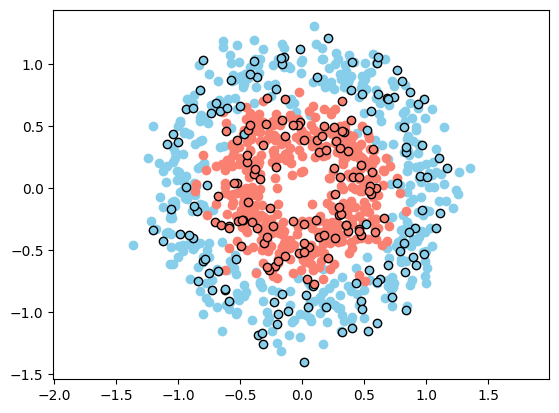

In [71]:
# Dataset
dt = Dataset(n = 1000, noise = 0.14, type = 'circles')
dt.split(0.80)
dt.plot(data = 'traintest')

In [69]:
# Network
topology = [2,6,8,5,1]
NN = NeuralNetwork(topology, 'sigm')
print(NN)

(0) Input (Act: None)                          O    O                 

(1) Hidden (Act: sigmoid)            O    O    O    O    O    O       

(2) Hidden (Act: sigmoid)       O    O    O    O    O    O    O    O  

(3) Hidden (Act: sigmoid)              O    O    O    O    O          

(4) Output (Act: sigmoid)                        O                    




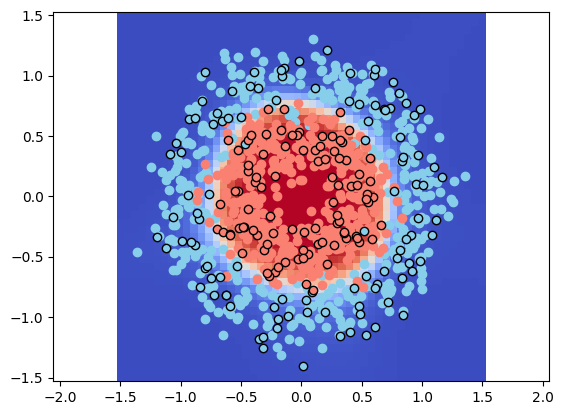

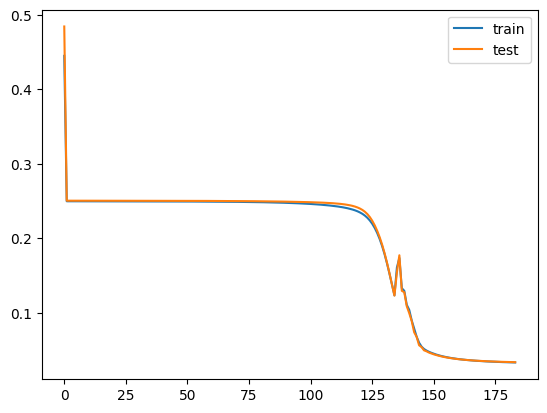

KeyboardInterrupt: 

In [72]:
NN.train(X_train = dt.X_train, Y_train = dt.Y_train,
         X_test = dt.X_test, Y_test = dt.Y_test,
         cost_function = 'MSE', learning_rate = 0.003,
         epochs = 20000, store_loss = 25, 
         animate = True, speed = 100)